# Neural Networks for MNIST dataset

In [3]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import numpy as np

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Loading MNIST
Here we load the dataset and create data loaders.

In [5]:
train_ds = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_ds = datasets.MNIST('data', train=False, download=True, 
                       transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [6]:
batch_size = 32
#batch_size = 5 # for testing
kwargs = {'num_workers': 4, 'pin_memory': True} 

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, **kwargs)

## Looking at Examples

In [7]:
train_dl = iter(train_loader)
x, y = next(train_dl)

In [8]:
print(x.shape, y.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Helper method (from fast.ai)

In [9]:
def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [10]:
# first from torch to numpy
X = x.numpy(); Y = y.numpy()
X.shape

(32, 1, 28, 28)

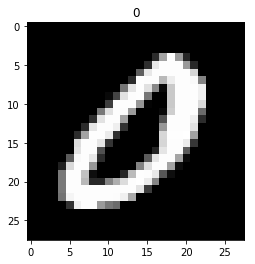

In [11]:
show(X[0][0], Y[0])

In [12]:
print(X[0][0][:4][:4])

[[-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296]
 [-0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296 -0.42421296
  -0.42421

## Feed Forward Neural Network

In [13]:
# for the number of neurons in the hidden unit
def get_model(M = 300):
    net = nn.Sequential(nn.Linear(28*28, M),
                        nn.ReLU(),
                        nn.Linear(M, 10))
    return net #.cuda()

In [14]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28).cuda()
            labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
            if (i+1) % 100 == 0:
                print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
        print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
        print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [15]:
def model_accuracy_loss(model, test_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).sum().item()
    return 100 * correct / total, sum_loss/ total

In [16]:
net = get_model().cuda()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
model_accuracy_loss(net, test_loader)

(8.5, 2.3198746158599852)

In [26]:
train_model(train_loader, test_loader, num_epochs=2, model=net, optimizer=optimizer)

Epoch [1/2], Loss: 0.7486
Epoch [1/2], Loss: 0.5785
Epoch [1/2], Loss: 0.5125
Epoch [1/2], Loss: 0.4748
Epoch [1/2], Loss: 0.4438
Epoch [1/2], Loss: 0.4206
Epoch [1/2], Loss: 0.4105
Epoch [1/2], Loss: 0.3973
Epoch [1/2], Loss: 0.3902
Epoch [1/2], Loss: 0.3798
Epoch [1/2], Loss: 0.3735
Epoch [1/2], Loss: 0.3671
Epoch [1/2], Loss: 0.3649
Epoch [1/2], Loss: 0.3634
Epoch [1/2], Loss: 0.3640
Epoch [1/2], Loss: 0.3581
Epoch [1/2], Loss: 0.3544
Epoch [1/2], Loss: 0.3485
Epoch [1/2], Loss: 0.3447
Epoch [1/2], Valid Accuracy: 92.6800, Valid Loss: 0.2820
Epoch [2/2], Loss: 0.3400
Epoch [2/2], Loss: 0.3359
Epoch [2/2], Loss: 0.3309
Epoch [2/2], Loss: 0.3284
Epoch [2/2], Loss: 0.3270
Epoch [2/2], Loss: 0.3232
Epoch [2/2], Loss: 0.3209
Epoch [2/2], Loss: 0.3188
Epoch [2/2], Loss: 0.3171
Epoch [2/2], Loss: 0.3136
Epoch [2/2], Loss: 0.3123
Epoch [2/2], Loss: 0.3113
Epoch [2/2], Loss: 0.3104
Epoch [2/2], Loss: 0.3089
Epoch [2/2], Loss: 0.3081
Epoch [2/2], Loss: 0.3069
Epoch [2/2], Loss: 0.3053
Epoch [

(93.03, 0.276409143280983, 0.302553220307827)

## Models with L2 regularization
To add L2 regularization use the `weight_decay` argument on the optimizer

In [17]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay = 0.01)

## Models with Dropout

In [18]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules) #.cuda()

In [19]:
net = get_model_v2(M = 300, p=0.1).cuda()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [32]:
train_model(train_loader, test_loader, num_epochs=4, model=net, optimizer=optimizer)

Epoch [1/4], Loss: 0.7191
Epoch [1/4], Loss: 0.5809
Epoch [1/4], Loss: 0.5241
Epoch [1/4], Loss: 0.5067
Epoch [1/4], Loss: 0.4952
Epoch [1/4], Loss: 0.4795
Epoch [1/4], Loss: 0.4704
Epoch [1/4], Loss: 0.4627
Epoch [1/4], Loss: 0.4533
Epoch [1/4], Loss: 0.4485
Epoch [1/4], Loss: 0.4426
Epoch [1/4], Loss: 0.4351
Epoch [1/4], Loss: 0.4332
Epoch [1/4], Loss: 0.4304
Epoch [1/4], Loss: 0.4258
Epoch [1/4], Loss: 0.4229
Epoch [1/4], Loss: 0.4220
Epoch [1/4], Loss: 0.4206
Epoch [1/4], Loss: 0.4192
Epoch [1/4], Valid Accuracy: 91.9100, Valid Loss: 0.3146
Epoch [2/4], Loss: 0.4123
Epoch [2/4], Loss: 0.4052
Epoch [2/4], Loss: 0.3987
Epoch [2/4], Loss: 0.3942
Epoch [2/4], Loss: 0.3895
Epoch [2/4], Loss: 0.3830
Epoch [2/4], Loss: 0.3775
Epoch [2/4], Loss: 0.3761
Epoch [2/4], Loss: 0.3730
Epoch [2/4], Loss: 0.3695
Epoch [2/4], Loss: 0.3666
Epoch [2/4], Loss: 0.3635
Epoch [2/4], Loss: 0.3636
Epoch [2/4], Loss: 0.3612
Epoch [2/4], Loss: 0.3597
Epoch [2/4], Loss: 0.3583
Epoch [2/4], Loss: 0.3561
Epoch [

(93.34, 0.3389083451986313, 0.30440951741337774)

#### Different learning rates

In [20]:
def train_model(train_loader, test_loader, num_epochs, model, optimizer):
    model.train()
    sum_loss = 0.0
    total = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            batch = images.shape[0] # size of the batch
            # Convert torch tensor to Variable, change shape of the input
            images = images.view(-1, 28*28).cuda()
            labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels.cuda())
            loss.backward()
            optimizer.step()
        
            total += batch
            sum_loss += batch * loss.item()
#             if (i+1) % 100 == 0:
#                 print ('Epoch [%d/%d], Loss: %.4f' 
#                    %(epoch+1, num_epochs, sum_loss/total))
                
        train_loss = sum_loss/total
#         print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, train_loss))
        val_acc, val_loss = model_accuracy_loss(model, test_loader)
#         print('Epoch [%d/%d], Valid Accuracy: %.4f, Valid Loss: %.4f' %(epoch+1, num_epochs, val_acc, val_loss))
    return val_acc, val_loss, train_loss

In [36]:
import time

lrs = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
val_acc_list = []
val_loss_list = []
train_loss_list = []
lr_list = []

for l in lrs:
    start = time.time()
    net = get_model_v2(M = 300, p=0.1).cuda()
    optimizer = optim.Adam(net.parameters(), lr= l)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs = 10, model=net, optimizer=optimizer)
    end = time.time()
    lr_list.append(l)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)
    print('lr of value : ',l, ' finished in ', end-start, ' secs')
    
    

lr of value :  1  finished in  96.86830401420593  secs
lr of value :  0.1  finished in  97.49245381355286  secs
lr of value :  0.01  finished in  95.55545020103455  secs
lr of value :  0.001  finished in  94.7211492061615  secs
lr of value :  0.0001  finished in  94.26864171028137  secs
lr of value :  1e-05  finished in  97.41456198692322  secs


In [37]:
print(lr_list)
print(train_loss_list)
print(val_loss_list)
print(val_acc_list)

[1, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[6.715851014779409, 2.3658197514724733, 0.2538151095507542, 0.057895181021727624, 0.12552360342601934, 0.3919103501987457]
[2.72065295791626, 2.311489500427246, 0.32766912140846255, 0.12037180772423745, 0.06759599306583404, 0.2236744359254837]
[11.37, 11.38, 94.36, 97.72, 97.9, 93.78]


>* The highest validation accuracy occurs at lr = 1e-4 followed by 1e-3. Interpolated value would be 5*1e-4
* However 1e-4 has underfitting since train loss is more than valid loss.
* We could train it for more epochs to get much higher accuracy. I would choose 1e-4
* 1e-3 has overfitting since after 10 epochs there is significant gap between train and valid loss.

In [41]:
net = get_model_v2(M = 300, p=0.1).cuda()
optimizer = optim.Adam(net.parameters(), lr= 5e-4)
train_model(train_loader, test_loader, num_epochs=4, model=net, optimizer=optimizer)

Epoch [1/4], Loss: 0.7857
Epoch [1/4], Loss: 0.5903
Epoch [1/4], Loss: 0.4985
Epoch [1/4], Loss: 0.4481
Epoch [1/4], Loss: 0.4097
Epoch [1/4], Loss: 0.3824
Epoch [1/4], Loss: 0.3629
Epoch [1/4], Loss: 0.3420
Epoch [1/4], Loss: 0.3274
Epoch [1/4], Loss: 0.3168
Epoch [1/4], Loss: 0.3036
Epoch [1/4], Loss: 0.2929
Epoch [1/4], Loss: 0.2829
Epoch [1/4], Loss: 0.2746
Epoch [1/4], Loss: 0.2661
Epoch [1/4], Loss: 0.2599
Epoch [1/4], Loss: 0.2536
Epoch [1/4], Loss: 0.2467
Epoch [1/4], Loss: 0.2428
Epoch [1/4], Valid Accuracy: 96.4900, Valid Loss: 0.1173
Epoch [2/4], Loss: 0.2368
Epoch [2/4], Loss: 0.2295
Epoch [2/4], Loss: 0.2243
Epoch [2/4], Loss: 0.2190
Epoch [2/4], Loss: 0.2139
Epoch [2/4], Loss: 0.2093
Epoch [2/4], Loss: 0.2050
Epoch [2/4], Loss: 0.2007
Epoch [2/4], Loss: 0.1974
Epoch [2/4], Loss: 0.1940
Epoch [2/4], Loss: 0.1905
Epoch [2/4], Loss: 0.1873
Epoch [2/4], Loss: 0.1842
Epoch [2/4], Loss: 0.1817
Epoch [2/4], Loss: 0.1790
Epoch [2/4], Loss: 0.1762
Epoch [2/4], Loss: 0.1739
Epoch [

(97.8, 0.07184602416753769, 0.11301818922708431)

In [43]:
net = get_model_v2(M = 300, p=0.1).cuda()
optimizer = optim.Adam(net.parameters(), lr= 5e-2)
train_model(train_loader, test_loader, num_epochs=4, model=net, optimizer=optimizer)

Epoch [1/4], Loss: 3.6033
Epoch [1/4], Loss: 2.5936
Epoch [1/4], Loss: 2.2497
Epoch [1/4], Loss: 2.0579
Epoch [1/4], Loss: 1.9637
Epoch [1/4], Loss: 1.8969
Epoch [1/4], Loss: 1.8437
Epoch [1/4], Loss: 1.8183
Epoch [1/4], Loss: 1.7832
Epoch [1/4], Loss: 1.7738
Epoch [1/4], Loss: 1.7541
Epoch [1/4], Loss: 1.7400
Epoch [1/4], Loss: 1.7268
Epoch [1/4], Loss: 1.7209
Epoch [1/4], Loss: 1.7166
Epoch [1/4], Loss: 1.7211
Epoch [1/4], Loss: 1.7372
Epoch [1/4], Loss: 1.7486
Epoch [1/4], Loss: 1.7525
Epoch [1/4], Valid Accuracy: 33.4400, Valid Loss: 1.7334
Epoch [2/4], Loss: 1.7547
Epoch [2/4], Loss: 1.7631
Epoch [2/4], Loss: 1.7639
Epoch [2/4], Loss: 1.7649
Epoch [2/4], Loss: 1.7603
Epoch [2/4], Loss: 1.7586
Epoch [2/4], Loss: 1.7563
Epoch [2/4], Loss: 1.7591
Epoch [2/4], Loss: 1.7584
Epoch [2/4], Loss: 1.7610
Epoch [2/4], Loss: 1.7595
Epoch [2/4], Loss: 1.7588
Epoch [2/4], Loss: 1.7575
Epoch [2/4], Loss: 1.7602
Epoch [2/4], Loss: 1.7563
Epoch [2/4], Loss: 1.7539
Epoch [2/4], Loss: 1.7599
Epoch [

(34.49, 1.7245856410980225, 1.709817103354136)

#### Different M

In [27]:
def get_model_v2(M = 300, p=0):
    modules = []
    modules.append(nn.Linear(28*28, M))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M, 10))
    return nn.Sequential(*modules) #.cuda()

In [56]:
val_acc_list = []
val_loss_list = []
train_loss_list = []
m_list = []

for m in [10, 50, 100, 300, 1000, 2000]:
    start = time.time()
    net = get_model_v2(M = m, p=0.1).cuda()
    optimizer = optim.Adam(net.parameters(), lr= 0.01)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=10, model=net, optimizer=optimizer)
    end = time.time()
    m_list.append(m)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)
    print('m of value : ',m, ' finished in ', end-start, ' secs')

m of value :  10  finished in  93.06841278076172  secs
m of value :  50  finished in  91.42460584640503  secs
m of value :  100  finished in  93.33778929710388  secs
m of value :  300  finished in  96.1435878276825  secs
m of value :  1000  finished in  94.00119709968567  secs
m of value :  2000  finished in  94.15414667129517  secs


In [57]:
print(m_list)
print(train_loss_list)
print(val_loss_list)
print(val_acc_list)

[10, 50, 100, 300, 1000, 2000]
[0.5268350938767195, 0.25601559507350125, 0.25069431071341036, 0.2527236468789975, 0.2619733847383658, 0.26501839753011863]
[0.4530211345911026, 0.325758491563797, 0.3040672090291977, 0.31717646474838257, 0.35150576248168947, 0.3478338025569916]
[86.9, 92.83, 94.49, 94.01, 93.84, 93.95]


>* High value of m doesnt necessarily give high accuracy. M=100 seems more than enough to get a good accuracy
* As the value of M increases we see that the gap between train and test loss increases, this is a sign of overfitting. Infact all the M values have overfitting to some extent, M=100 seems to have low loss and difference in them

#### Different weight decay

In [62]:
val_acc_list = []
val_loss_list = []
train_loss_list = []
w_list = []

for w in [0, 0.0001, 0.001, 0.01, 0.1, 0.3]:
    start = time.time()
    net = get_model_v2(M = 300, p=0.1).cuda()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = w)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs= 20, model=net, optimizer=optimizer)
    end = time.time()
    w_list.append(w)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)
    print('w of value : ',w, ' finished in ', end-start, ' secs')
    
    

w of value :  0  finished in  190.87114310264587  secs
w of value :  0.0001  finished in  190.3960416316986  secs
w of value :  0.001  finished in  191.3861222267151  secs
w of value :  0.01  finished in  190.59041953086853  secs
w of value :  0.1  finished in  190.22906470298767  secs
w of value :  0.3  finished in  189.7286970615387  secs


Weights, train loss, validation loss and corresponding accuracy in order

In [63]:
print(w_list)
print(train_loss_list)
print(val_loss_list)
print(val_acc_list)

[0, 0.0001, 0.001, 0.01, 0.1, 0.3]
[0.03736692767158694, 0.04608046758000429, 0.08024183318475882, 0.17785113293965657, 0.47795682656089467, 0.8252347141687075]
[0.12801459040492774, 0.0981404365748167, 0.08314272434711456, 0.15468035526275634, 0.43538561849594115, 0.7967260702133179]
[98.01, 97.63, 97.4, 95.96, 89.73, 83.82]


>* As we increase the weight decay we see that the difference between train and test lost and narrowing.
* Increasing weight decay regularizes the model and prevents overfitting

Different drop outs

In [33]:
val_acc_list = []
val_loss_list = []
train_loss_list = []
p_list = []

for p in range(1,11,2):
    start = time.time()
    net = get_model_v2(M = 300, p= p/10).cuda()
    optimizer = optim.Adam(net.parameters(), lr= 0.001)
    val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs=20, model=net, optimizer=optimizer)
    end = time.time()
    p_list.append(p/10)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)
    print('p of value : ',p*.1, ' finished in ', end-start, ' secs')

p of value :  0.1  finished in  199.75901675224304  secs
p of value :  0.30000000000000004  finished in  202.6267592906952  secs
p of value :  0.5  finished in  200.17301273345947  secs
p of value :  0.7000000000000001  finished in  200.4196605682373  secs
p of value :  0.9  finished in  203.41671013832092  secs


In [34]:
print(val_acc_list)
print(val_loss_list)
print(train_loss_list)
print(p_list)

[98.06, 97.9, 98.0, 97.77, 98.12]
[0.12519292316585778, 0.1423546568222344, 0.1484976174585521, 0.15545272355973722, 0.13591364087313412]
[0.037634527406005654, 0.03948624798679802, 0.041978019182002946, 0.05022911171152373, 0.07868764867369978]
[0.1, 0.3, 0.5, 0.7, 0.9]


>* All the pvalues seem to have underfitting for the given value of learning rate.
* A pvalue of 0.9 which gives highest accuracy, seems way to high for regularizarion, may be fewer neurons are required to predict this simple data set

>* Dropouts give consistently higher accuracy on test data than L2 regularization

>* What we learnt from the past experiments is that dropout work better than L2 norm in regularization .
* Learning rate of 1e-3 or lesser is suitable for this data set
* Increasing the complexity by adding more neurons doesnt help. Thus for the second layer we will use, less than 100 neurons

>**3 layer neural network**
* Explore with different values of M for model complexity and drop out (p) for regularization at lr = 1e-3 for first 10 epochs and lr = 1e-4 for last 10 epochs

In [22]:
def get_model_v3(M , p=0):
    modules = []
    modules.append(nn.Linear(28*28, M[0]))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M[0], M[1]))
    modules.append(nn.ReLU())
    if p > 0:
        modules.append(nn.Dropout(p))
    modules.append(nn.Linear(M[1], 10))
    return nn.Sequential(*modules) #.cuda()

In [25]:
v_a = []
v_l = []
t_l = []
M_l = []
p_l = []
for M in [(300,50),(200,50),(100,50),(300,30),(200,30),(100,30) ]:
    for p in [0,0.3,0.6,0.9]:
        print('M:',M,' p: ',p)
        net = get_model_v3(M = M , p= p ).cuda()
        optimizer = optim.Adam(net.parameters(), lr= 0.001)
        val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs= 10, model=net, optimizer=optimizer)
        optimizer = optim.Adam(net.parameters(), lr= 0.001/10)
        val_acc, val_loss, train_loss = train_model(train_loader, test_loader, num_epochs= 10, model=net, optimizer=optimizer)
        print('Val loss: ', val_loss, ' train loss: ', train_loss, 'Val acc: ', val_acc)
        v_a.append(val_acc)
        v_l.append(val_loss)
        t_l.append(train_loss)
        M_l.append(M)
        p_l.append(p)

M: (300, 50)  p:  0
Val loss:  0.10497654397487641  train loss:  0.0011925701274474463 Val acc:  98.51
M: (300, 50)  p:  0.3
Val loss:  0.08720177454948426  train loss:  0.013398607277969519 Val acc:  98.65
M: (300, 50)  p:  0.6
Val loss:  0.09738736186623573  train loss:  0.0991202541384101 Val acc:  98.38
M: (300, 50)  p:  0.9
Val loss:  0.08702810008525848  train loss:  1.052563990974898 Val acc:  97.96
M: (200, 50)  p:  0
Val loss:  0.10517750310897828  train loss:  0.0013800404571493467 Val acc:  98.38
M: (200, 50)  p:  0.3
Val loss:  0.09688276602327824  train loss:  0.01718268789857626 Val acc:  98.52
M: (200, 50)  p:  0.6
Val loss:  0.08872469582855702  train loss:  0.1340936478992303 Val acc:  98.39
M: (200, 50)  p:  0.9
Val loss:  0.08800620893239974  train loss:  1.3761993934600303 Val acc:  97.62
M: (100, 50)  p:  0
Val loss:  0.0917570155620575  train loss:  0.002572277473707994 Val acc:  98.14
M: (100, 50)  p:  0.3
Val loss:  0.08755594239234925  train loss:  0.0346077568

The highest accuracy seems to come from M= (300,50) for first and second layer with drop out of 0.3